# Paper Replication: (Re-)Imag(in)ing Price Trends

In [16]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

### Load and Batch the Data
1. Load the 20-day OHLC images data (with Moving average Line, Volume bars) provided by Yuan Yao.
2. Divide the sample into training (79%), validation (30%) from 1993-2000 and test samples from 2001-2019. 



In [17]:
import pandas as pd
import numpy as np
import os.path as op
import torch
IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}

class ImageDataset(torch.utils.data.Dataset):
    """
    ImageDataset inherit troch.utils.data, it requires __init__(), __getitem__(), __len__()
    It can achieve the goal that combine two tensor data to tensor dataset
    You can use index to get the data from the datasets, and len to get the size of the datasets
    """
    
    def __init__(self, image, label):
        self.image = image
        self.label = label
        
    def __getitem__(self, index):
        return self.image[index], self.label[index]
    
    def __len__(self):
        return self.image.size(0)
    

# Loading and appending datasets
datasets = []
label_df_list=[] #store label dataframes

for year in range(1993, 2020):
    images = np.memmap(op.join("../Data/img_data_yao/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, 1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    label_df = pd.read_feather(op.join("../Data/img_data_yao/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
    
    #select label and keep nomissing label observations
    label = label_df["Retx_20d_label"]
    label_df_new = label_df.loc[label<2,:] #select all the labels after dropping missing future re
    images = images[label<2]
    label = label[label<2]
    
    #conver to tensor
    images_tensor = torch.from_numpy(images)
    label_tensor = torch.tensor(label.values)
    
    images_tensor = images_tensor.float()
    label_tensor = label_tensor.long()
    data = ImageDataset(images_tensor, label_tensor)
    
    # append results
    datasets.append(data)
    label_df_list.append(label_df_new)

# divide sample into two parts
train_set=torch.utils.data.ConcatDataset(datasets[:8]) #first seven years as training set 
test_set=torch.utils.data.ConcatDataset(datasets[8:]) #the rest as test set
test_label_df=pd.concat(label_df_list[8:]) #for merging the signal back

In [18]:
### Load and Batch the Data
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

def create_datasets(batch_size, train_set, test_set):

    # percentage of training set to use as validation
    valid_size = 0.3

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = train_set

    test_data = test_set

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader


### Define the Network
- 5 $\times$ 3 convolutional filter and 2 $\times$ 1 max-pooling filters.
- use the same filter sizes in all layers
- use horizontal and vertical strides of 1 and vertical dilation rates of 2 for 20-day images, only on the first layer because raw images are sparse.
- use 3 blocks for 20-day images
- increase the number of filters after each convolutional layer by a factor of two (64, 128, 256)
- fully connected layers have 46080 neurons 20-day models
- total number of parameters are 708866 for 20-day

In [19]:
# CZ
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #block1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5,3), stride=(1,1), dilation = (4,1), padding = (0,1))
        nn.init.xavier_uniform_(self.conv1.weight)
        self.norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.01)
        self.pool1 = nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1))
        #block2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,3), stride=(1,1), dilation = (1,1),padding = (0,1))
        nn.init.xavier_uniform_(self.conv2.weight)
        self.norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.01)
        self.pool2 = nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1))
        #block3
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(5,3), stride=(1,1), dilation = (1,1),padding = (0,1))
        nn.init.xavier_uniform_(self.conv3.weight)
        self.norm3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.01)
        self.pool3 = nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1))
        
        self.fc = nn.Linear(256*3*60, 2)
        self.drop = nn.Dropout(p=0.5)
        
        self.classifier = nn.Softmax(dim=-1)

    def forward(self, x):
        y = self.conv1(x)
        y = self.norm1(y)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.norm2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = self.conv3(y)
        y = self.norm3(y)
        y = self.relu3(y)
        y = self.pool3(y)
        y = y.view(y.shape[0], -1)
        y = self.fc(y)
        y = self.drop(y)
        y = self.classifier(y)
        return y

# initialize the NN
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1), dilation=(4, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1))
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=46080, out_features=2, bias=T

In [20]:
# use GPU to train the model if possible
import os
from torchsummary import summary

use_gpu = torch.cuda.is_available()
# use_gpu = False
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if use_gpu else "cpu")
if use_gpu:
    model = model.cuda()
    
# summarize the model and training methods
print(device)
summary(model, input_size=(1, 64, 60), device="cuda" if use_gpu else "cpu") 

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 60]           1,024
       BatchNorm2d-2           [-1, 64, 48, 60]             128
         LeakyReLU-3           [-1, 64, 48, 60]               0
         MaxPool2d-4           [-1, 64, 24, 60]               0
            Conv2d-5          [-1, 128, 20, 60]         123,008
       BatchNorm2d-6          [-1, 128, 20, 60]             256
         LeakyReLU-7          [-1, 128, 20, 60]               0
         MaxPool2d-8          [-1, 128, 10, 60]               0
            Conv2d-9           [-1, 256, 6, 60]         491,776
      BatchNorm2d-10           [-1, 256, 6, 60]             512
        LeakyReLU-11           [-1, 256, 6, 60]               0
        MaxPool2d-12           [-1, 256, 3, 60]               0
           Linear-13                    [-1, 2]          92,162
          Dropout-14              

### Specify Loss Function and Optimizer

In [21]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
learning_rate = 1e-6
#optimizer = optim.SGD(model.parameters(), lr=learning_rate) #SGD
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

import torch.optim as optim

### Import the Early Stopping Class

In [22]:
# import EarlyStopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Train the Model using Early Stopping

In [23]:
import time

def train_model(model, batch_size, patience, n_epochs, device):
    since = time.time()
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping objectAA
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # send your input tensors to the CPU/GPU
            if use_gpu:
                    data = data.cuda()
                    target = target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # send your input tensors to the CPU/GPU
            if use_gpu:
                    data = data.cuda()
                    target = target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    # report the time on training
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    )
    
    return  model, avg_train_losses, avg_valid_losses

In [25]:
batch_size = 128
n_epochs = 30
# early stopping patience; how long to wait after last time validation loss improved.
patience = 2
train_loader, test_loader, valid_loader = create_datasets(batch_size, train_set, test_set)

In [9]:
model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs, device)

[ 1/30] train_loss: 0.69974 valid_loss: 0.69462
Validation loss decreased (inf --> 0.694624).  Saving model ...
[ 2/30] train_loss: 0.69640 valid_loss: 0.69384
Validation loss decreased (0.694624 --> 0.693839).  Saving model ...
[ 3/30] train_loss: 0.69479 valid_loss: 0.69270
Validation loss decreased (0.693839 --> 0.692704).  Saving model ...
[ 4/30] train_loss: 0.69379 valid_loss: 0.69203
Validation loss decreased (0.692704 --> 0.692032).  Saving model ...
[ 5/30] train_loss: 0.69271 valid_loss: 0.69165
Validation loss decreased (0.692032 --> 0.691651).  Saving model ...
[ 6/30] train_loss: 0.69183 valid_loss: 0.69131
Validation loss decreased (0.691651 --> 0.691309).  Saving model ...
[ 7/30] train_loss: 0.69130 valid_loss: 0.69105
Validation loss decreased (0.691309 --> 0.691054).  Saving model ...
[ 8/30] train_loss: 0.69041 valid_loss: 0.69074
Validation loss decreased (0.691054 --> 0.690741).  Saving model ...
[ 9/30] train_loss: 0.68997 valid_loss: 0.69073
Validation loss decre

In [14]:
#save trained model
path = './ImageModel_cz.pt'
torch.save(model.state_dict(), path)

### Visualizing the Loss and the Early Stopping Checkpoint
From the plot we can see that the last Early Stopping Checkpoint was saved right before the model started to overfit.

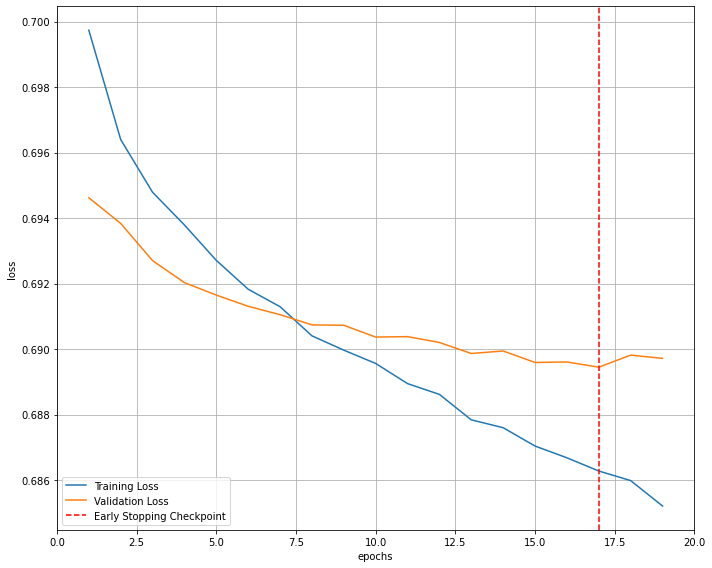

In [10]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim(0, 1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

### Test the Trained Network

In [26]:
#load model parameter
path = './ImageModel_cz.pt'
model = model

if use_gpu:
    model.load_state_dict(torch.load(path))
    model = model.cuda()
else:
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [30]:
since = time.time()

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # send your input tensors to the CPU/GPU
    if use_gpu:
            data = data.cuda()
            target = target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

time_elapsed = time.time() - since
print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Test Loss: 0.693488

Test Accuracy of     0: 57% (395447/685365)
Test Accuracy of     1: 46% (327351/709323)

Test Accuracy (Overall): 51% (722798/1394688)
Testing complete in 7m 6s


In [31]:
since = time.time()

# initialize lists for predictors
predicted=[] #predicted up and downs for test sample
prob_up=[] #probability of up
prob_down=[] #probability of down

model.eval() # prep model for evaluation

for data, target in test_loader:
    # send your input tensors to the CPU/GPU
    if use_gpu:
            data = data.cuda()
            target = target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    _, pred = torch.max(output, 1)
    
    # save the predictors.
    predicted.extend(pred.tolist())
    prob_down.extend(output.T[0].tolist())#down probability
    prob_up.extend(output.T[1].tolist())#up probability

time_elapsed = time.time() - since
print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Testing complete in 2m 43s


In [33]:
#merge prediction results to label dataframe
test_label_df['Predicted']=predicted
test_label_df['Prob_Up']=prob_up
test_label_df['Prob_Down']=prob_down

df = test_label_df.loc[:,['Date','StockID','Retx_20d','Retx_20d_label','Predicted','Prob_Up','Prob_Down']]
df.to_csv('../Data/predictors.csv', index=False)

### Visualize Sample Test Results

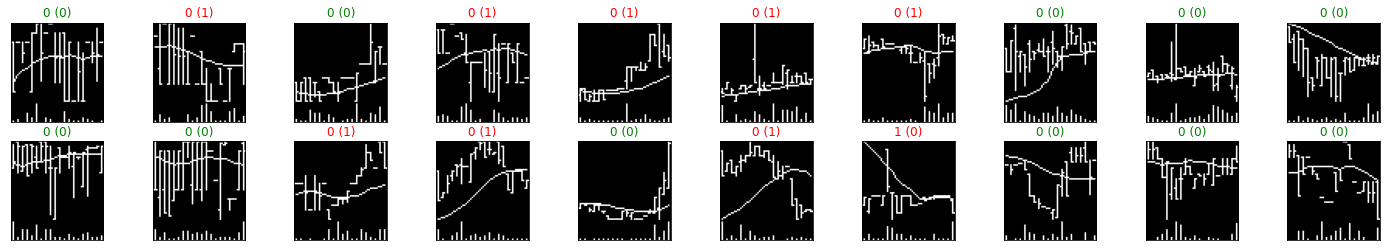

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

model = model.cpu()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## References

The MNIST training example code is mainly taken from the [mnist_mlp_solution_with_validation.ipynb](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution_with_validation.ipynb) notebook from the [deep-learning-v2-pytorch repository](https://github.com/udacity/deep-learning-v2-pytorch) made by [Udacity](https://www.udacity.com/), and has been fitted with my early stopping code. 